In [4]:
from topicnet.cooking_machine import Dataset
import pandas as pd

dataset = Dataset('MKB10.csv', batch_vectorizer_path="./mkb_batches2")

data_orig = pd.read_pickle("MKB10.pkl")


In [19]:
data_orig.title = data_orig.title.str.replace(" ", "_")


In [5]:
dataset.get_possible_modalities()

{'@letter', '@ngram', '@text'}

In [6]:

import numpy as np

# all articles are from category "Симптомы по алфавиту", so threshold is 1
THRESHOLD = 1

def randomly_select(data_orig, point_a, should_intersect):
    attempts_left = 100
    while attempts_left > 0:
        rnd_idx_b = np.random.choice(data_orig.shape[0])
        point_b = data_orig.iloc[rnd_idx_b]
        intersection = set(point_b.categories) & set(point_a.categories)
        is_big = (len(intersection) > THRESHOLD)
        if should_intersect == is_big:
            # if is_big:
            #    print(point_a.title, point_b.title, intersection)
            return point_b.title, rnd_idx_b, intersection
        attempts_left -= 1
    return None, None, None

def generate_triplet(data_orig):

    rnd_idx_a = np.random.choice(data_orig.shape[0])
    point_a = data_orig.iloc[rnd_idx_a]
    point_b, rnd_idx_b, intersection = randomly_select(data_orig, point_a, should_intersect=True)
    point_c, rnd_idx_c, empty_intersection = randomly_select(data_orig, point_a, should_intersect=False)
    # return [point_a, point_b, point_c]
    return [point_a.title, point_b, point_c, intersection]
    # return [rnd_idx_a, rnd_idx_b, rnd_idx_c]

    
    

In [21]:
from tqdm import tqdm

triplets = []

for i in tqdm(range(10000)):
    a, b, c, explanation = generate_triplet(data_orig)
    if b is not None and c is not None:
        triplets.append( (a, b, c, explanation) )

len(triplets)

100%|██████████| 10000/10000 [00:57<00:00, 173.50it/s]


7221

In [22]:
import pickle

with open("triplets_mkb.p", "wb") as f:
    pickle.dump(triplets, f)


## Scoring model by ranking quality

In [23]:
from topicnet.cooking_machine.models import BaseScore as BaseTopicNetScore, TopicModel


class ValidationRankingQuality(BaseTopicNetScore):
    def __init__(self, validation_dataset, triplets):
        super().__init__()

        self.validation_dataset = validation_dataset
        self.triplets = triplets

    def call(self, model: TopicModel):
        theta = model.get_theta(dataset=self.validation_dataset)
        
        correct_rankings = 0

        for (a, b, c, _) in self.triplets:
            # L1 distance, just for example
            similar_dist = sum(abs(theta[a] - theta[b]))
            diffrnt_dist = sum(abs(theta[a] - theta[c]))

            correct_rankings += (similar_dist < diffrnt_dist)

        return correct_rankings / len(self.triplets)

        

In [24]:
import artm

artm_model = artm.ARTM(
    num_topics=20, 
    dictionary=dataset.get_dictionary(),
    class_ids={'@lemmatized': 1, '@ngram': 50},  # absolute values, just for example
    theta_columns_naming="title"
)



In [25]:
tm = TopicModel(artm_model, custom_scores={"ranking": ValidationRankingQuality(dataset, triplets)})

In [26]:
tm._fit(dataset.get_batch_vectorizer(), 10)

0.641600886303836


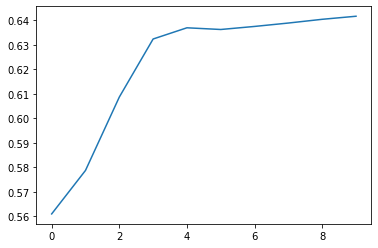

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

print(tm.scores['ranking'][-1])
plt.plot(tm.scores['ranking'])

In [28]:
theta = artm_model.transform(batch_vectorizer=dataset.get_batch_vectorizer())

In [30]:
for (a, b, c, explanation) in triplets[:10]:
    # L1 distance, just for example
    similar_dist = sum(abs(theta[a] - theta[b])) 
    diffrnt_dist = sum(abs(theta[a] - theta[c]))

    if (similar_dist > diffrnt_dist):
        print(a, b, c)
        print(explanation)


Асимптоматический_хронический_простатит Некротический_фасциит Болезнь_Галлервордена_—_Шпатца
{'Синдромы по алфавиту', 'Бактериальные инфекции'}
Листериоз Трихофития Дермацентороз
{'Инфекционные заболевания', 'Синдромы по алфавиту'}
Гестоз Маловодие Психогенное_переедание
{'Патология беременности', 'Синдромы по алфавиту'}
